# Importações

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import sys
import os

# Dados Meteo

In [2]:
sys.path.append(os.path.abspath(".."))
from meteorology.data.meteorology_data import GetMeteorologyData
df = GetMeteorologyData()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29973 entries, 0 to 29972
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   datetime          29973 non-null  datetime64[ns]
 1   temp              29973 non-null  float64       
 2   feelslike         29973 non-null  float64       
 3   dew               29973 non-null  float64       
 4   humidity          29973 non-null  float64       
 5   precip            28966 non-null  float64       
 6   precipprob        29973 non-null  float64       
 7   preciptype        804 non-null    object        
 8   windgust          2088 non-null   float64       
 9   windspeed         29966 non-null  float64       
 10  winddir           29790 non-null  float64       
 11  sealevelpressure  29973 non-null  float64       
 12  cloudcover        22653 non-null  float64       
 13  visibility        29967 non-null  float64       
 14  conditions        2997

In [3]:
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')

# Selecionar só as colunas temp e precip e fazer o resample diário com média
df = df[['temp', 'precip']].resample('D').mean()

# contadores corrigidos

In [4]:
df_corrigido_final = pd.read_csv(r"C:\Users\joana\Desktop\Projeto\construcao_modelos\df_corrigido_final.csv")

# Novo indice

In [5]:
def calcular_indice_uteis_fds(df, coluna='count_', plotar=True, cores=None):
    df = df.copy()
    df = df.set_index('datetime')

    # Separar dias úteis e não úteis com base na coluna exog
    df_uteis = df[df['exog'] != 1]
    df_nao_uteis = df[df['exog'] == 1]

    # Média semanal com resample
    media_uteis = df_uteis[coluna].resample('W-MON').mean()
    media_nao_uteis = df_nao_uteis[coluna].resample('W-MON').mean()

    # Combinar os dois em um único DataFrame
    medias = pd.concat([media_uteis, media_nao_uteis], axis=1)
    medias.columns = ['media_uteis', 'media_nao_uteis']
    medias = medias.dropna(how='all')  # remover semanas totalmente vazias

    # Calcular os índices
    medias['indice_uteis_não_uteis'] = medias['media_uteis'] / medias['media_nao_uteis']

    # Extrair ano e semana para plotagem
    medias['ano'] = medias.index.isocalendar().year
    medias['semana'] = medias.index.isocalendar().week

    if plotar:
        anos = sorted(medias['ano'].unique())
        if cores is None:
            cmap = plt.cm.tab10
            cores = {ano: cmap(i % 10) for i, ano in enumerate(anos)}

        plt.figure(figsize=(12, 6))

        for ano in anos:
            dados_ano = medias[medias['ano'] == ano]
            plt.plot(dados_ano['semana'], dados_ano['indice_uteis_não_uteis'],
                     marker='o', linestyle='-', label=f'Ano {ano}', color=cores[ano])

        plt.yscale('log', base=2)
        plt.axhline(1, color='red', linestyle='--', label='Índice = 1')
        plt.title('Índice: Média Úteis / Média Não Úteis (semanal, via resample)')
        plt.xlabel('Semana do Ano')
        plt.ylabel('Índice')
        plt.xlim(1, 53)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return medias

In [6]:
df_corrigido_final = df_corrigido_final.rename(columns={'detected': 'datetime'})
df_corrigido_final['datetime'] = pd.to_datetime(df_corrigido_final['datetime'])

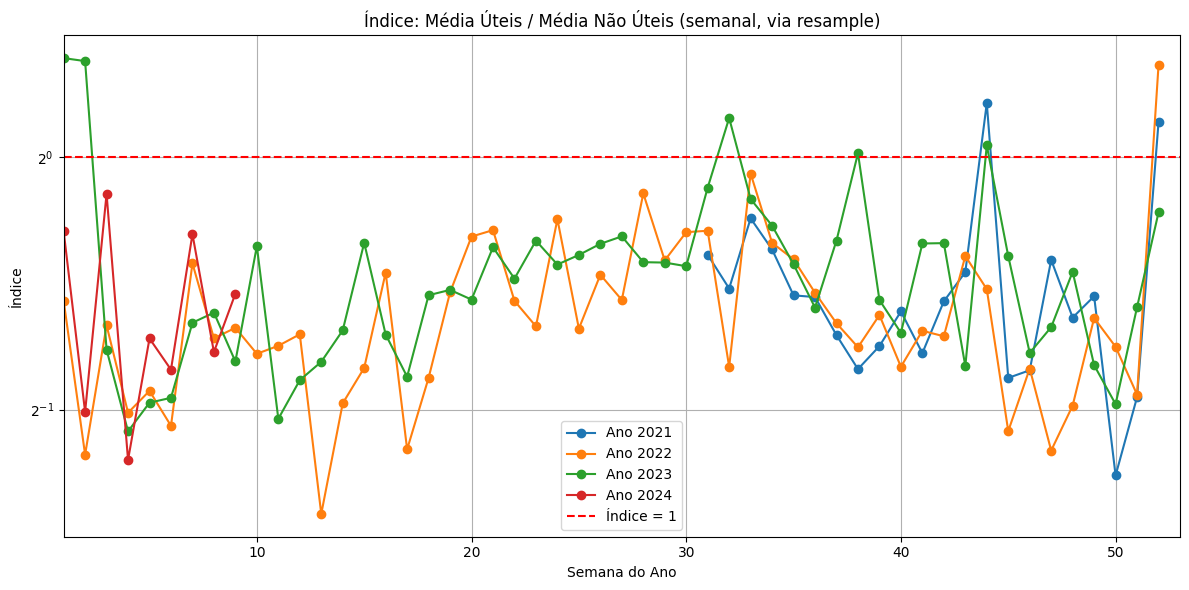

In [7]:
df_12= calcular_indice_uteis_fds(df_corrigido_final, coluna='count_12', plotar=True)

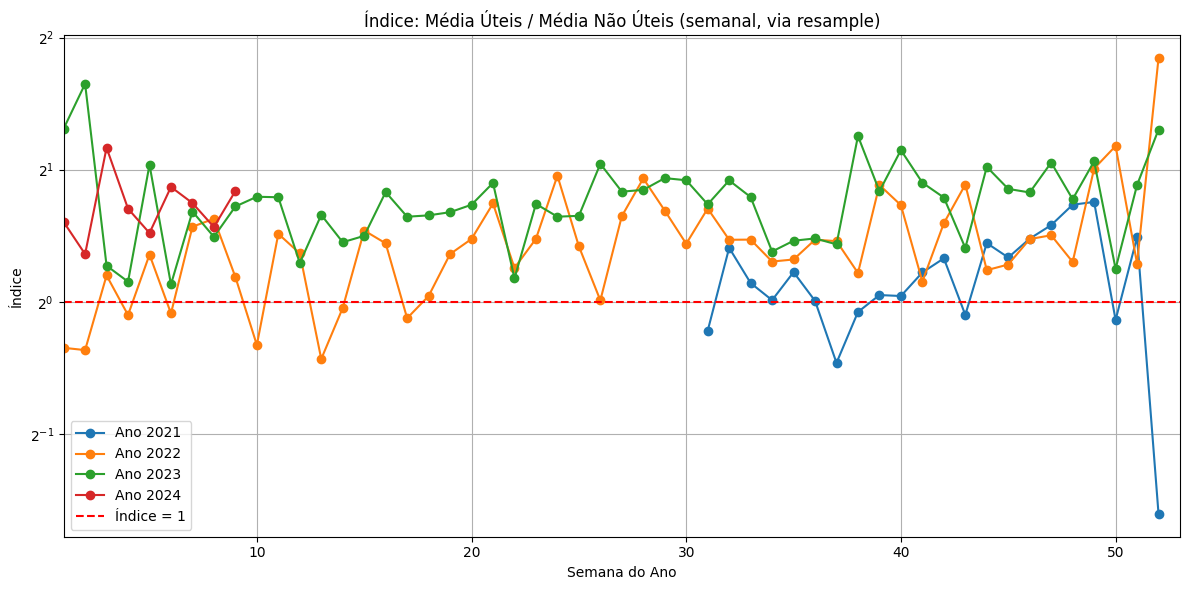

In [8]:
df_8= calcular_indice_uteis_fds(df_corrigido_final, coluna='count_8', plotar=True)

### Novo indice + meteo

In [9]:
df.index = pd.to_datetime(df.index)
df_meteo_semanal = df.resample('W-MON').mean().reset_index()
df_meteo_semanal.columns = ['semana_data', 'temp', 'precip'] 

In [10]:
df_meteo_semanal

,semana_data,temp,precip
0,2021-08-02,21.135417,0.000000
1,2021-08-09,21.719048,0.000000
2,2021-08-16,24.116071,0.000000
3,2021-08-23,22.513095,0.000000
4,2021-08-30,21.120238,0.011185
...,...,...,...
175,2024-12-09,13.858929,0.023271
176,2024-12-16,8.967857,0.030797
177,2024-12-23,12.345833,0.029762
178,2024-12-30,10.432738,0.000000


In [11]:
df_12 = df_12.reset_index()
df_8 = df_8.reset_index()

In [12]:
df_12.rename(columns={'datetime': 'semana_data'}, inplace=True)
df_8.rename(columns={'datetime': 'semana_data'}, inplace=True)

In [13]:
df_12 = pd.merge(df_12, df_meteo_semanal, on='semana_data', how='left')
df_8 = pd.merge(df_8, df_meteo_semanal, on='semana_data', how='left')

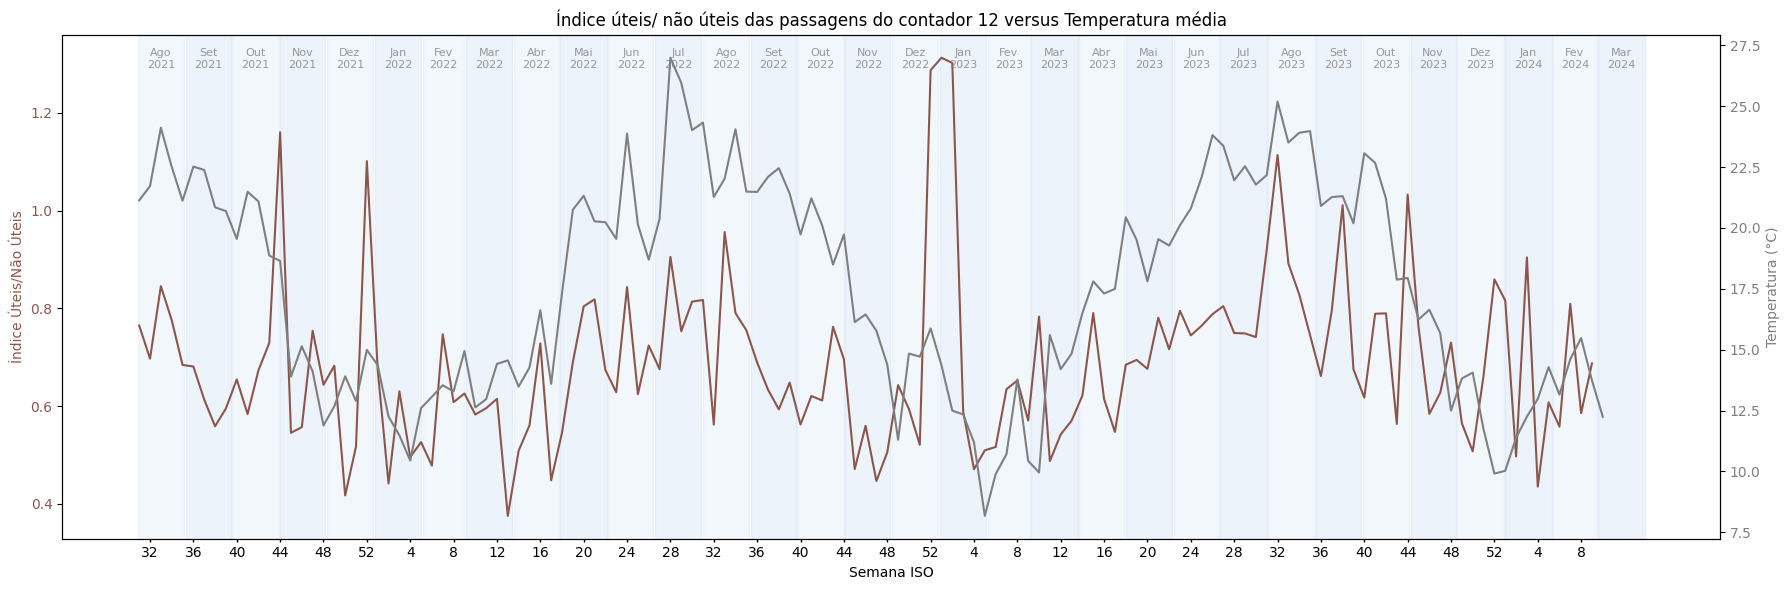

In [38]:
import locale
locale.setlocale(locale.LC_TIME, 'pt_PT.UTF-8')

df_sorted_12 = df_12.sort_values('semana_data')
df_sorted_12 = df_sorted_12.sort_values('semana_data')
df_sorted_12['semana_ano'] = df_sorted_12['semana_data'].dt.isocalendar().week

fig, ax1 = plt.subplots(figsize=(18,6))

# Gráfico para índice úteis/não úteis
ax1.plot(df_sorted_12['semana_data'], df_sorted_12['indice_uteis_não_uteis'], color='tab:brown', label='Índice Úteis/Não Úteis')
ax1.set_xlabel('Semana ISO')
ax1.set_ylabel('Índice Úteis/Não Úteis', color='tab:brown')
ax1.tick_params(axis='y', labelcolor='tab:brown')

# Segundo eixo y para temperatura
ax2 = ax1.twinx()
ax2.plot(df_sorted_12['semana_data'], df_sorted_12['temp'], color='tab:grey', label='Temperatura')
ax2.set_ylabel('Temperatura (°C)', color='tab:grey')
ax2.tick_params(axis='y', labelcolor='tab:grey')

# Título e layout
datas = df_sorted_12['semana_data']
min_data = datas.min()
max_data = datas.max()
inicio_sombreado = pd.Timestamp('2021-08-01')
if min_data > inicio_sombreado:
    min_data = inicio_sombreado

inicio_mes = pd.date_range(start=min_data, end=max_data, freq='MS')

for i, start in enumerate(inicio_mes):
    end = start + pd.offsets.MonthEnd(1)
    cor = (0.5, 0.7, 0.9, 0.1 + 0.05 * (i % 2))  # tons azul pastel alternados
    ax1.axvspan(start, end, color=cor)
    #ax1.axvline(start, color='lightgrey', linestyle='--', linewidth=0.5) linhas em cizento entre os meses

        # Nome do mês
    mid = start + (end - start) / 2
    nome_mes = f"{start.strftime('%b').capitalize()}\n{start.year}"
    ax1.text(mid, ax1.get_ylim()[1]*0.98, nome_mes,
                    ha='center', va='top', fontsize=8, color='gray', alpha=0.8)

semanas_para_ticks = df_sorted_12[df_sorted_12['semana_ano'] % 4 == 0]
ticks_locs = mdates.date2num(semanas_para_ticks['semana_data'])
ticks_labels = [str(w) for w in semanas_para_ticks['semana_ano']]
    
ax1.set_xticks(ticks_locs)
ax1.set_xticklabels(ticks_labels)
ax1.tick_params(axis='x', which='major', length=2, width=1)
plt.title('Índice úteis/ não úteis das passagens do contador 12 versus Temperatura média')
fig.tight_layout()
plt.show()


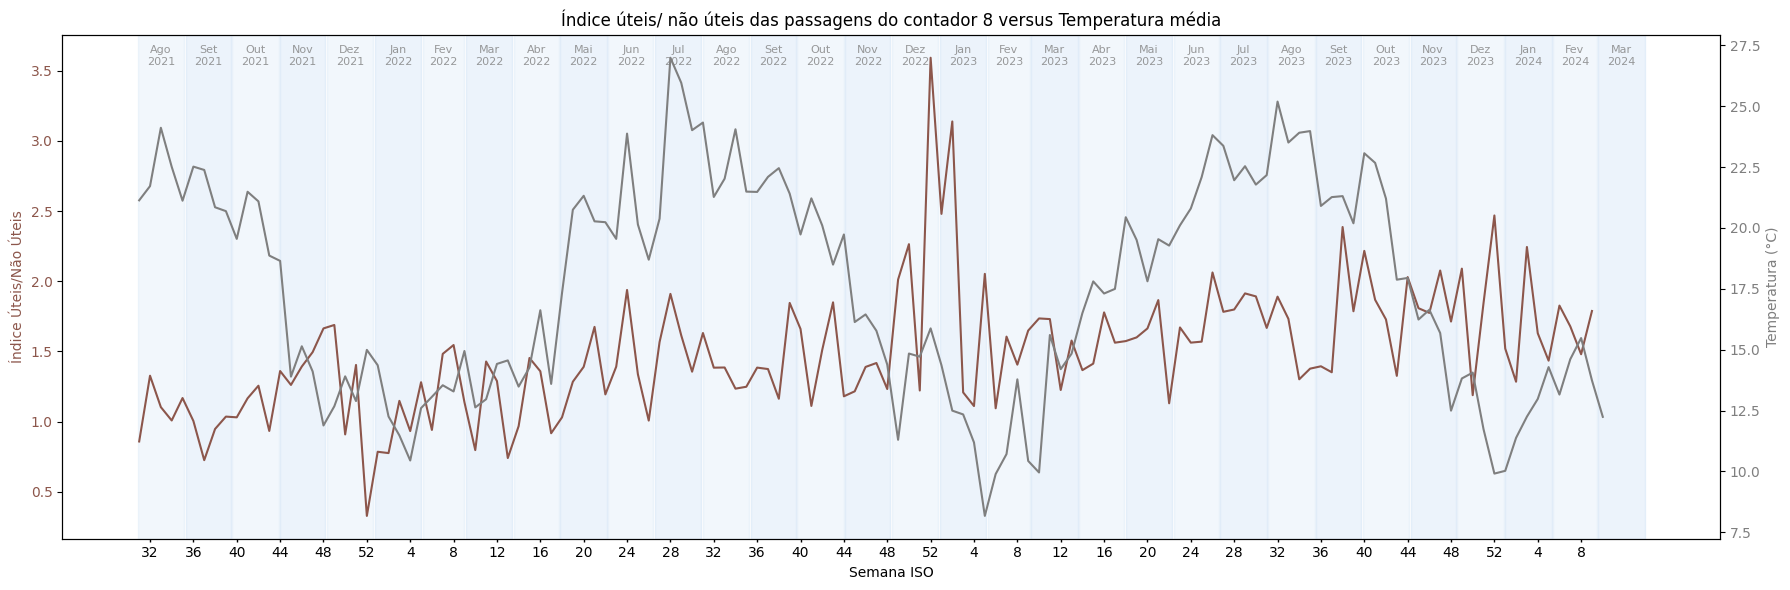

In [39]:
import locale
locale.setlocale(locale.LC_TIME, 'pt_PT.UTF-8')

df_sorted_8 = df_8.sort_values('semana_data')
df_sorted_8 = df_sorted_8.sort_values('semana_data')
df_sorted_8['semana_ano'] = df_sorted_8['semana_data'].dt.isocalendar().week

fig, ax1 = plt.subplots(figsize=(18,6))

# Gráfico para índice úteis/não úteis
ax1.plot(df_sorted_8['semana_data'], df_sorted_8['indice_uteis_não_uteis'], color='tab:brown', label='Índice Úteis/Não Úteis')
ax1.set_xlabel('Semana ISO')
ax1.set_ylabel('Índice Úteis/Não Úteis', color='tab:brown')
ax1.tick_params(axis='y', labelcolor='tab:brown')

# Segundo eixo y para temperatura
ax2 = ax1.twinx()
ax2.plot(df_sorted_8['semana_data'], df_sorted_8['temp'], color='tab:grey', label='Temperatura')
ax2.set_ylabel('Temperatura (°C)', color='tab:grey')
ax2.tick_params(axis='y', labelcolor='tab:grey')

# Título e layout
datas = df_sorted_8['semana_data']
min_data = datas.min()
max_data = datas.max()
inicio_sombreado = pd.Timestamp('2021-08-01')
if min_data > inicio_sombreado:
    min_data = inicio_sombreado

inicio_mes = pd.date_range(start=min_data, end=max_data, freq='MS')

for i, start in enumerate(inicio_mes):
    end = start + pd.offsets.MonthEnd(1)
    cor = (0.5, 0.7, 0.9, 0.1 + 0.05 * (i % 2))  # tons azul pastel alternados
    ax1.axvspan(start, end, color=cor)
    #ax1.axvline(start, color='lightgrey', linestyle='--', linewidth=0.5) linhas em cizento entre os meses

        # Nome do mês
    mid = start + (end - start) / 2
    nome_mes = f"{start.strftime('%b').capitalize()}\n{start.year}"
    ax1.text(mid, ax1.get_ylim()[1]*0.98, nome_mes,
                    ha='center', va='top', fontsize=8, color='gray', alpha=0.8)

semanas_para_ticks = df_sorted_8[df_sorted_8['semana_ano'] % 4 == 0]
ticks_locs = mdates.date2num(semanas_para_ticks['semana_data'])
ticks_labels = [str(w) for w in semanas_para_ticks['semana_ano']]
    
ax1.set_xticks(ticks_locs)
ax1.set_xticklabels(ticks_labels)
ax1.tick_params(axis='x', which='major', length=2, width=1)
plt.title('Índice úteis/ não úteis das passagens do contador 8 versus Temperatura média')
fig.tight_layout()
plt.show()